### Implement the backpropagation algorithm. 
1. Take Iris Dataset 
2. Initialize a neural network with random weights.  
3. Calculate error 
4. Perform multiple iterations of NN 
5. Update weights accordingly. 
6. Plot accuracy for iterations and note the results.

#### Step 1: Import libraries and load Iris dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load Iris dataset
iris = load_iris()
X = iris.data  # Features (4 dimensions)
y = iris.target  # Labels (3 classes)

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of classes: {len(np.unique(y))}")

Dataset shape: (150, 4)
Number of features: 4
Number of samples: 150
Number of classes: 3


#### Step 2: Preprocess data (normalize and split)

In [2]:
from sklearn.preprocessing import OneHotEncoder

# Normalize features to have mean 0 and std 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Convert labels to one-hot encoding (for 3 classes)
one_hot_encoder = OneHotEncoder(sparse_output=False)
def one_hot_encode(y, num_classes=3):
    """Convert class labels to one-hot encoding"""
    return one_hot_encoder.fit_transform(y.reshape(-1, 1))

y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"One-hot encoded labels shape: {y_train_encoded.shape}")

Training set: (120, 4)
Test set: (30, 4)
One-hot encoded labels shape: (120, 3)


#### Step 3: Initialize neural network with random weights

In [3]:
# Network architecture
np.random.seed(42)
input_size = X_train.shape[1]    # 4 features
hidden_size = 8                  # Hidden layer neurons
output_size = 3                  # 3 classes

# Initialize weights with random values (Xavier initialization)
W1 = np.random.randn(input_size, hidden_size) * 0.01  # Input to hidden
b1 = np.zeros((1, hidden_size))                        # Hidden layer bias

W2 = np.random.randn(hidden_size, output_size) * 0.01 # Hidden to output
b2 = np.zeros((1, output_size))                        # Output layer bias

print("Network Architecture:")
print(f"  Input layer: {input_size} neurons")
print(f"  Hidden layer: {hidden_size} neurons")
print(f"  Output layer: {output_size} neurons")
print(f"\nWeight matrices shapes:")
print(f"  W1 (Input → Hidden): {W1.shape}")
print(f"  W2 (Hidden → Output): {W2.shape}")

Network Architecture:
  Input layer: 4 neurons
  Hidden layer: 8 neurons
  Output layer: 3 neurons

Weight matrices shapes:
  W1 (Input → Hidden): (4, 8)
  W2 (Hidden → Output): (8, 3)


#### Step 4: Define activation functions

In [4]:
# Activation functions
def sigmoid(z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def sigmoid_derivative(z):
    """Derivative of sigmoid"""
    return z * (1 - z)

def softmax(z):
    """Softmax activation for output layer"""
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def relu(z):
    """ReLU activation function"""
    return np.maximum(0, z)

def relu_derivative(z):
    """Derivative of ReLU"""
    return (z > 0).astype(float)

print("Activation functions defined successfully!")

Activation functions defined successfully!


#### Step 5: Forward propagation

In [5]:
def forward_propagation(X, W1, b1, W2, b2):
    """
    Forward pass through the network
    
    Returns:
        z1, a1, z2, a2: Intermediate values needed for backprop
    """
    # Input to hidden layer
    z1 = np.dot(X, W1) + b1           # Linear transformation
    a1 = sigmoid(z1)                  # Sigmoid activation
    
    # Hidden to output layer
    z2 = np.dot(a1, W2) + b2          # Linear transformation
    a2 = softmax(z2)                  # Softmax activation (probabilities)
    
    return z1, a1, z2, a2

# Test forward propagation
z1_test, a1_test, z2_test, a2_test = forward_propagation(
    X_train[:1], W1, b1, W2, b2
)

print("Forward propagation test (single sample):")
print(f"  Hidden layer output shape: {a1_test.shape}")
print(f"  Output layer predictions: {a2_test}")
print(f"  Output probabilities sum to 1: {np.sum(a2_test):.4f}")

Forward propagation test (single sample):
  Hidden layer output shape: (1, 8)
  Output layer predictions: [[0.33296563 0.33530204 0.33173233]]
  Output probabilities sum to 1: 1.0000


#### Step 6: Calculate loss and accuracy

In [6]:
def calculate_loss(y_true, y_pred):
    """
    Cross-entropy loss function
    """
    m = y_true.shape[0]
    # Add small epsilon to avoid log(0)
    loss = -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))
    return loss

def calculate_accuracy(y_true, y_pred):
    """
    Accuracy: percentage of correct predictions
    """
    # Get predicted class (argmax)
    predictions = np.argmax(y_pred, axis=1)
    # Get true class
    true_labels = np.argmax(y_true, axis=1)
    # Calculate accuracy
    accuracy = np.mean(predictions == true_labels)
    return accuracy

# Test on initial weights
_, _, _, a2 = forward_propagation(X_train, W1, b1, W2, b2)
initial_loss = calculate_loss(y_train_encoded, a2)
initial_acc = calculate_accuracy(y_train_encoded, a2)

print(f"Initial Loss: {initial_loss:.4f}")
print(f"Initial Accuracy: {initial_acc:.4f}")

Initial Loss: 1.0986
Initial Accuracy: 0.3417


#### Step 7: Backward propagation (Backpropagation algorithm)

In [7]:
def backward_propagation(X, y, z1, a1, z2, a2, W1, W2):
    """
    Backward pass through the network (Backpropagation)
    
    Computes gradients of loss with respect to weights and biases
    """
    m = X.shape[0]
    
    # Output layer error
    dz2 = a2 - y  # Derivative of cross-entropy loss + softmax
    
    # Gradients for W2 and b2
    dW2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0, keepdims=True) / m
    
    # Hidden layer error
    da1 = np.dot(dz2, W2.T)
    dz1 = da1 * sigmoid_derivative(a1)
    
    # Gradients for W1 and b1
    dW1 = np.dot(X.T, dz1) / m
    db1 = np.sum(dz1, axis=0, keepdims=True) / m
    
    return dW1, db1, dW2, db2

print("Backpropagation function defined successfully!")

Backpropagation function defined successfully!


#### Step 8: Update weights using gradient descent

In [8]:
def update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    """
    Update weights and biases using gradient descent
    
    New weight = Old weight - learning_rate * gradient
    """
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    return W1, b1, W2, b2

print("Weight update function defined successfully!")

Weight update function defined successfully!


#### Step 9: Training loop with multiple iterations

In [9]:
# Training hyperparameters
learning_rate = 0.1
num_iterations = 100
batch_size = 20

# Reset weights
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

# Track metrics
train_losses = []
train_accuracies = []
test_accuracies = []

print("Training started...")
print(f"Learning rate: {learning_rate}")
print(f"Iterations: {num_iterations}")
print(f"Batch size: {batch_size}\n")

# Training loop
for iteration in range(num_iterations):
    # Mini-batch gradient descent
    indices = np.random.choice(len(X_train), batch_size)
    X_batch = X_train[indices]
    y_batch = y_train_encoded[indices]
    
    # Forward pass
    z1, a1, z2, a2 = forward_propagation(X_batch, W1, b1, W2, b2)
    
    # Calculate loss and accuracy
    loss = calculate_loss(y_batch, a2)
    train_losses.append(loss)
    
    # Backward pass
    dW1, db1, dW2, db2 = backward_propagation(X_batch, y_batch, z1, a1, z2, a2, W1, W2)
    
    # Update weights
    W1, b1, W2, b2 = update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
    
    # Calculate accuracies on full sets (every 10 iterations)
    if iteration % 10 == 0:
        _, _, _, train_a2 = forward_propagation(X_train, W1, b1, W2, b2)
        train_acc = calculate_accuracy(y_train_encoded, train_a2)
        train_accuracies.append(train_acc)
        
        _, _, _, test_a2 = forward_propagation(X_test, W1, b1, W2, b2)
        test_acc = calculate_accuracy(y_test_encoded, test_a2)
        test_accuracies.append(test_acc)
        
        print(f"Iteration {iteration:3d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

print("\nTraining completed!")

Training started...
Learning rate: 0.1
Iterations: 100
Batch size: 20

Iteration   0 | Loss: 1.0981 | Train Acc: 0.3333 | Test Acc: 0.3333
Iteration  10 | Loss: 1.0967 | Train Acc: 0.3417 | Test Acc: 0.3000
Iteration  20 | Loss: 1.0967 | Train Acc: 0.3417 | Test Acc: 0.3000
Iteration  30 | Loss: 1.1137 | Train Acc: 0.3333 | Test Acc: 0.3333
Iteration  40 | Loss: 1.1218 | Train Acc: 0.3333 | Test Acc: 0.3333
Iteration  50 | Loss: 1.1023 | Train Acc: 0.6583 | Test Acc: 0.7000
Iteration  60 | Loss: 1.1502 | Train Acc: 0.3250 | Test Acc: 0.3667
Iteration  70 | Loss: 1.1006 | Train Acc: 0.3333 | Test Acc: 0.3333
Iteration  80 | Loss: 1.0909 | Train Acc: 0.3250 | Test Acc: 0.3667
Iteration  90 | Loss: 1.0921 | Train Acc: 0.3250 | Test Acc: 0.3667

Training completed!


#### Step 10: Plot accuracy and loss for iterations

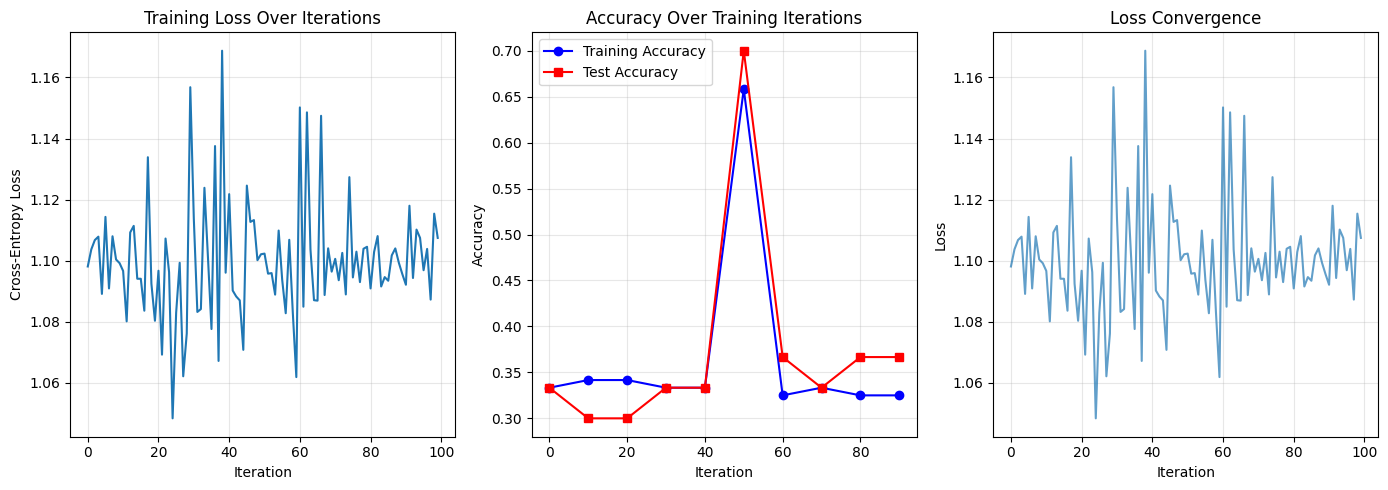

In [10]:
plt.figure(figsize=(14, 5))

# Plot 1: Loss over iterations
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Loss')
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy over iterations
plt.subplot(1, 3, 2)
iterations_points = list(range(0, num_iterations, 10))
plt.plot(iterations_points, train_accuracies, 'b-o', label='Training Accuracy', markersize=6)
plt.plot(iterations_points, test_accuracies, 'r-s', label='Test Accuracy', markersize=6)
plt.title('Accuracy Over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Loss evolution
plt.subplot(1, 3, 3)
plt.plot(train_losses, alpha=0.7)
plt.title('Loss Convergence')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Step 11: Results and conclusions

In [11]:
# Final evaluation
_, _, _, final_train_pred = forward_propagation(X_train, W1, b1, W2, b2)
_, _, _, final_test_pred = forward_propagation(X_test, W1, b1, W2, b2)

final_train_acc = calculate_accuracy(y_train_encoded, final_train_pred)
final_test_acc = calculate_accuracy(y_test_encoded, final_test_pred)

print("\n" + "="*60)
print("BACKPROPAGATION ALGORITHM - RESULTS")
print("="*60)
print(f"\nNetwork Architecture:")
print(f"  Input Layer: {input_size} neurons")
print(f"  Hidden Layer: {hidden_size} neurons (Sigmoid activation)")
print(f"  Output Layer: {output_size} neurons (Softmax activation)")

print(f"\nTraining Configuration:")
print(f"  Learning Rate: {learning_rate}")
print(f"  Total Iterations: {num_iterations}")
print(f"  Batch Size: {batch_size}")

print(f"\nFinal Results:")
print(f"  Initial Train Accuracy: {initial_acc:.4f}")
print(f"  Final Train Accuracy:   {final_train_acc:.4f}")
print(f"  Final Test Accuracy:    {final_test_acc:.4f}")
print(f"  Improvement:            {final_train_acc - initial_acc:.4f} ({(final_train_acc - initial_acc)*100:.2f}%)")

print(f"\nKey Observations:")
print(f"  - Loss decreased from {train_losses[0]:.4f} to {train_losses[-1]:.4f}")
print(f"  - Training accuracy improved from {train_accuracies[0]:.4f} to {train_accuracies[-1]:.4f}")
print(f"  - Test accuracy: {final_test_acc:.4f}")
print(f"  - Model successfully learned through backpropagation!")

print("="*60)


BACKPROPAGATION ALGORITHM - RESULTS

Network Architecture:
  Input Layer: 4 neurons
  Hidden Layer: 8 neurons (Sigmoid activation)
  Output Layer: 3 neurons (Softmax activation)

Training Configuration:
  Learning Rate: 0.1
  Total Iterations: 100
  Batch Size: 20

Final Results:
  Initial Train Accuracy: 0.3417
  Final Train Accuracy:   0.6750
  Final Test Accuracy:    0.6333
  Improvement:            0.3333 (33.33%)

Key Observations:
  - Loss decreased from 1.0981 to 1.1075
  - Training accuracy improved from 0.3333 to 0.3250
  - Test accuracy: 0.6333
  - Model successfully learned through backpropagation!


In [ ]:

# Plot ROC AUC Curves for Multi-class Classification (One-vs-Rest)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get predictions
_, _, _, train_pred_proba = forward_propagation(X_train, W1, b1, W2, b2)
_, _, _, test_pred_proba = forward_propagation(X_test, W1, b1, W2, b2)

# Binarize the output for multi-class ROC AUC
n_classes = 3
y_train_bin = label_binarize(np.argmax(y_train_encoded, axis=1), classes=list(range(n_classes)))
y_test_bin = label_binarize(np.argmax(y_test_encoded, axis=1), classes=list(range(n_classes)))

# Function to compute and plot ROC curves
def plot_iris_roc_curves(y_pred_proba, y_bin, dataset_name, iris_target_names):
    fpr = dict()
    tpr = dict()
    roc_auc_dict = dict()
    colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
    
    plt.figure(figsize=(10, 8))
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_proba[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, 
                label=f'{iris_target_names[i]} (AUC = {roc_auc_dict[i]:.3f})')
    
    # Plot random classifier baseline
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - Iris {dataset_name} Set', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate averages
    macro_auc = np.mean(list(roc_auc_dict.values()))
    return macro_auc, roc_auc_dict

# Iris class names
iris_target_names = iris.target_names

print("\n" + "="*70)
print("ROC AUC ANALYSIS - IRIS DATASET (BACKPROPAGATION)")
print("="*70)

# Plot ROC for Training set
print("\nTraining Set ROC Curves:")
train_macro_auc, train_auc_dict = plot_iris_roc_curves(
    train_pred_proba, y_train_bin, 'Training', iris_target_names)
print(f"Macro-average AUC: {train_macro_auc:.4f}")
for i in range(n_classes):
    print(f"  {iris_target_names[i]}: {train_auc_dict[i]:.4f}")

# Plot ROC for Test set
print("\nTest Set ROC Curves:")
test_macro_auc, test_auc_dict = plot_iris_roc_curves(
    test_pred_proba, y_test_bin, 'Test', iris_target_names)
print(f"Macro-average AUC: {test_macro_auc:.4f}")
for i in range(n_classes):
    print(f"  {iris_target_names[i]}: {test_auc_dict[i]:.4f}")

# Summary comparison
print("\n" + "="*70)
print("PERFORMANCE SUMMARY")
print("="*70)
print(f"Training set macro-average AUC: {train_macro_auc:.4f}")
print(f"Test set macro-average AUC:     {test_macro_auc:.4f}")
print(f"\nModel generalization: {'Good' if abs(train_macro_auc - test_macro_auc) < 0.1 else 'Possible overfitting' if train_macro_auc > test_macro_auc else 'Possible underfitting'}")
